In [2]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
import qiskit
import cuquantum
# from cuquantum import *
import time
import opt_einsum

In [3]:
traindata = pd.read_csv('../Data/fashion-mnist-data/fashion-mnist_train.csv')

In [4]:
def data_per_class(label,ds_train,ds_test):
    filt = (traindata['label'] == label)
    one_class_train = traindata.loc[filt][:ds_train]
    one_class_test  = traindata.loc[filt][ds_train:ds_train+ds_test]
    return one_class_train, one_class_test

In [5]:
def fashion_data(data0,data1,n_dim):
    full_class = pd.concat([data0,data1]).sample(frac = 1)
    data_full  = full_class.iloc[:,1:785] / 255.0
    data_full  = StandardScaler().fit_transform(data_full)
    pca        = PCA(n_components=n_dim).fit(data_full)
    data_full  = pca.transform(data_full)   
    label_full = pd.DataFrame([full_class.iloc[:,0]]).T
    label_full = np.array(label_full).ravel()
    return data_full,label_full

In [6]:
# fashion_data function check
n_dim = 100
num_train = 500
num_test  = 50
class_lb = [0,1] 

data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)

In [7]:
# check train data
data_train, label_train = fashion_data(data_0_train,data_1_train,n_dim)
unique, counts = np.unique(label_train, return_counts=True)
print(unique, counts)
print(data_train.shape)
label_train[:50]

[0 1] [500 500]
(1000, 100)


array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0])

In [8]:
# check test data
data_test, label_test = fashion_data(data_0_test,data_1_test,n_dim)
unique, counts = np.unique(label_test, return_counts=True)
print(unique, counts)
print(data_test.shape)
label_test[:50]

[0 1] [50 50]
(100, 100)


array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0])

---

In [39]:
import os
from itertools import combinations,product
from multiprocessing import Pool
print(os.cpu_count())

32


In [10]:
def get_qc_circuit(x_t1, x_t2, n_dim):
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=1, entanglement="linear", insert_barriers=True)
    zz_kernel = QuantumKernel(feature_map=zz_map)  
    zz_circuit = zz_kernel.construct_circuit(x_t1,x_t2,measurement=False,is_statevector_sim=False)
    return zz_circuit

[-5.66374927 28.87321313] [-5.66374927 28.87321313]


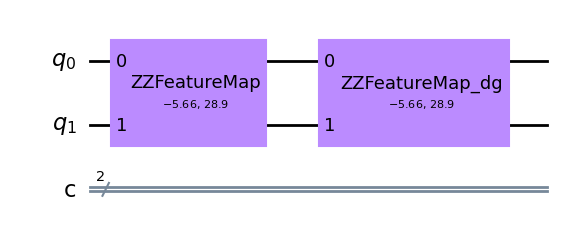

In [11]:
# get_qc_circuit function check
n_dim = 2
num_train = 20
num_test  = 2
class_lb = [0,1] 

data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)
data_train, label_train   = fashion_data(data_0_train,data_1_train,n_dim)
data_test, label_test     = fashion_data(data_0_test,data_1_test,n_dim)

qsvm_qc = get_qc_circuit(data_train[0],data_train[0],n_dim)
print(data_train[0],data_train[0])
qsvm_qc.decompose().draw('mpl')

In [12]:
def all_circuits(datasize, x_t, n_dim):
    t0 = time.time()
    
    circuits = []
    for i1, i2 in combinations(range(1, datasize + 1), 2):
        cir = get_qc_circuit(x_t[i1-1], x_t[i2-1], n_dim)
        circuits.append(cir)
    print("Time =", time.time()-t0)
    return circuits

In [13]:
# all_circuits function check 
circuits = all_circuits(num_train*2, data_train, n_dim)
print(np.sum(np.arange(1,40)))
len(circuits)

Time = 5.422504425048828
780


780

In [38]:
def all_circuits_parallel(datasize, x_t, n_dim, num_cpu = 12):
    t0 = time.time()

    # Use Pool to parallelize the computation of circuits
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        indices_list = list(combinations(range(1, datasize + 1), 2))
        circuits = pool.starmap(get_qc_circuit, [(x_t[i1-1], x_t[i2-1], n_dim) for i1, i2 in indices_list])
    print("Time =", time.time() - t0)
    return circuits

In [15]:
# all_circuits_parallel function check 
circuits_p = all_circuits_parallel(num_train*2, data_train, n_dim)
print(np.sum(np.arange(1,40)))
len(circuits_p)

Time = 1.445021152496338
780


780

---

test compare cuquantum,opt_einsum,numpy

In [16]:
n_dim = 2
num_train = 10
num_test  = 2
class_lb = [0,1] 

data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)
data_train, label_train   = fashion_data(data_0_train,data_1_train,n_dim)

qsvm_qc = get_qc_circuit(data_train[0],data_train[0],n_dim)
# print(data_train[0],data_train[0])

In [17]:
converter = cuquantum.CircuitToEinsum(qsvm_qc, backend='numpy')
a = str(0).zfill(n_dim)
exp, oper = converter.amplitude(a)
path, info = cuquantum.contract_path(exp, *oper)

# %timeit np.einsum(exp, *oper)
%timeit opt_einsum.contract(exp, *oper)
%timeit cuquantum.contract(exp, *oper)
%timeit cuquantum.contract(exp, *oper, optimize = {'path' : path})  

1.68 ms ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
11.5 ms ± 576 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.25 ms ± 734 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
converter = cuquantum.CircuitToEinsum(qsvm_qc, backend='cupy')
a = str(0).zfill(n_dim)
exp, oper = converter.amplitude(a)
path, info = cuquantum.contract_path(exp, *oper)

# %timeit np.einsum(exp, *oper)
%timeit opt_einsum.contract(exp, *oper)
%timeit cuquantum.contract(exp, *oper)
%timeit cuquantum.contract(exp, *oper, optimize = {'path' : path})  

3.95 ms ± 684 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.63 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.63 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


---

In [19]:
def get_path(circuit):
    converter = cuquantum.CircuitToEinsum(circuit, backend='numpy')
    a = str(0).zfill(n_dim)
    exp, oper = converter.amplitude(a)  
    return exp, oper

In [20]:
def all_operands(all_circuits,datasize):
    t0 = time.time()
    
    operands = []
    i = -1
    for i1 in range(2,datasize+1):
        for i2 in range(1,i1):
            i += 1
            _, oper = get_path(all_circuits[i])
            oper_gpu = [cp.asarray(tensor) for tensor in oper]
            operands.append(oper_gpu)
    print("Time =", time.time()-t0)
    
    return operands

In [21]:
def all_operands_parallel(all_circuits,num_cpu = 12):
    t0 = time.time()

    # Use Pool to parallelize the computation of operands
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        results = pool.map(get_path, all_circuits)

    operands = [[cp.asarray(tensor) for tensor in oper] for _, oper in results]
    print("Time =", time.time() - t0)

    return operands

In [22]:
# check all_operands_p with all_circuits_p
print('all_circuits_parallel + all_operands_parallel')
circuits_p = all_circuits_parallel(num_train*2, data_train, n_dim)
operands_p = all_operands_parallel(circuits_p,num_train*2)

all_circuits_parallel + all_operands_parallel
Time = 0.8409066200256348
Time = 0.7108280658721924


---

In [23]:
def get_kernel_matrix_cutensornet(operands,x_t,datasize,n_dim):
    kernel_matrix = cp.zeros((datasize,datasize))

    circuit = get_qc_circuit(x_t[0], x_t[0], n_dim)
    exp, _ = get_path(circuit)
    oper, i = operands[0], -1
    with cuquantum.Network(exp, *oper) as tn:
        path, info = tn.contract_path()
        t0 = time.time()
        for i1 in range(2,datasize+1):
            for i2 in range(1,i1):
                i += 1
                tn.reset_operands(*operands[i])
                amp = tn.contract()
                kernel_matrix[i1-1][i2-1] = cp.round(cp.sqrt(cp.square(amp.real)+cp.square(amp.imag)),5)
        kernel_matrix = kernel_matrix + kernel_matrix.T+cp.diag(cp.ones((datasize)))
        print("Time = ", time.time()-t0)
    
    return kernel_matrix

In [24]:
def get_kernel_matrix_opteinsum(operands,x_t,datasize,n_dim):
    kernel_matrix = cp.zeros((datasize,datasize))

    circuit = get_qc_circuit(x_t[0], x_t[0], n_dim)
    exp, _ = get_path(circuit)
    oper, i = operands[0], -1
    t0 = time.time()
    for i1 in range(2,datasize+1):
        for i2 in range(1,i1):
            i += 1
            amp = opt_einsum.contract(exp,*operands[i])
            kernel_matrix[i1-1][i2-1] = cp.round(cp.sqrt(cp.square(amp.real)+cp.square(amp.imag)),5)
    kernel_matrix = kernel_matrix + kernel_matrix.T+cp.diag(cp.ones((datasize)))
    print("Time = ", time.time()-t0)
    
    return kernel_matrix

In [25]:
# for cuquantum
circuits_p = all_circuits_parallel(num_train*2, data_train, n_dim)
operands_p = all_operands_parallel(circuits_p,num_train*2)
kernel_matrix_cutensornet = get_kernel_matrix_cutensornet(operands_p, data_train, num_train*2, n_dim)
kernel_matrix_opteinsum = get_kernel_matrix_opteinsum(operands_p, data_train, num_train*2, n_dim)

Time = 0.4339559078216553
Time = 0.7382369041442871
Time =  0.2984039783477783
Time =  0.6761229038238525


---

get test data

In [41]:
# get_qc_circuit function check
n_dim = 2
num_train = 20
num_test  = 2
class_lb = [0,1] 

data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)
data_train, label_train   = fashion_data(data_0_train,data_1_train,n_dim)
data_test, label_test     = fashion_data(data_0_test,data_1_test,n_dim)

In [44]:
def all_circuits_test_parallel(data1,data2, n_dim, num_cpu = 12):
    t0 = time.time()
    # Use Pool to parallelize the computation of circuits
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        indices_list = list(product(range(1, len(data1) + 1),range(1, len(data2) + 1)))
        circuits = pool.starmap(get_qc_circuit, [(data1[i1-1], data2[i2-1], n_dim) for i1, i2 in indices_list])
    print("Time =", time.time() - t0)
    return circuits

In [48]:
circuits = all_circuits_test_parallel(data_test,data_train,n_dim, num_cpu=32)
print(len(data_test)*len(data_train))
len(circuits)

Time = 0.7385029792785645
160


160

In [64]:
len(data_test),len(data_train)

(4, 40)

In [49]:
def get_path(circuit):
    converter = cuquantum.CircuitToEinsum(circuit, backend='numpy')
    a = str(0).zfill(n_dim)
    exp, oper = converter.amplitude(a)  
    return exp, oper

In [50]:
def all_operands_parallel(all_circuits,num_cpu = 32):
    t0 = time.time()
    # Use Pool to parallelize the computation of operands
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        results = pool.map(get_path, all_circuits)
    operands = [[cp.asarray(tensor) for tensor in oper] for _, oper in results]
    print("Time =", time.time() - t0)

    return operands

In [51]:
# check all_operands_p with all_circuits_p
print('all_circuits_parallel + all_operands_parallel')
circuits_p = all_circuits_test_parallel(data_test,data_train,n_dim, num_cpu=32)
operands_p = all_operands_parallel(circuits_p,num_train*2)

all_circuits_parallel + all_operands_parallel
Time = 0.7967543601989746
Time = 1.1562778949737549


In [62]:
def get_kernel_matrix_cutensornet_n(operands,x_t,datasize1,datasize2,n_dim):
    kernel_matrix = cp.zeros((datasize1,datasize2))

    circuit = get_qc_circuit(x_t[0], x_t[0], n_dim)
    exp, _ = get_path(circuit)
    oper, i = operands[0], -1
    with cuquantum.Network(exp, *oper) as tn:
        path, info = tn.contract_path()
        t0 = time.time()
        for i1 in range(1,datasize1+1):
            for i2 in range(1,datasize2+1):
                i += 1
                tn.reset_operands(*operands[i])
                amp = tn.contract()
                kernel_matrix[i1-1][i2-1] = cp.round(cp.sqrt(cp.square(amp.real)+cp.square(amp.imag)),5)
        print("Time = ", time.time()-t0)
    
    return kernel_matrix

In [71]:
# for cuquantum
circuits_p = all_circuits_test_parallel(data_test,data_train,n_dim, num_cpu=32)
operands_p = all_operands_parallel(circuits_p)
kernel_matrix_cutensornet = get_kernel_matrix_cutensornet_n(operands_p, data_train, len(data_test),len(data_train), n_dim)

Time = 1.4963786602020264
Time = 1.119154453277588
Time =  0.28539419174194336


In [68]:
kernel_matrix_cutensornet

array([[0.56134, 0.58545, 0.30704, 0.68243, 0.43488, 0.19485, 0.47118,
        0.01925, 0.22485, 0.40425, 0.4166 , 0.19903, 0.83337, 0.56082,
        0.29958, 0.39296, 0.44263, 0.43898, 0.35663, 0.44741, 0.64948,
        0.19166, 0.34809, 0.69326, 0.76432, 0.32308, 0.27413, 0.61255,
        0.27075, 0.64456, 0.52359, 0.40379, 0.33018, 0.59943, 0.65784,
        0.06901, 0.0646 , 0.41589, 0.20628, 0.24466],
       [0.1123 , 0.38433, 0.18901, 0.72055, 0.41111, 0.76075, 0.15817,
        0.68293, 0.7288 , 0.25688, 0.81267, 0.78061, 0.20607, 0.42072,
        0.65659, 0.70515, 0.3096 , 0.78002, 0.27217, 0.52455, 0.18951,
        0.29006, 0.948  , 0.54821, 0.28739, 0.17954, 0.20116, 0.20118,
        0.63223, 0.8127 , 0.22297, 0.45495, 0.5403 , 0.75224, 0.6871 ,
        0.21504, 0.45694, 0.39393, 0.91003, 0.14406],
       [0.37891, 0.53373, 0.70692, 0.10469, 0.36351, 0.57182, 0.3154 ,
        0.70826, 0.10262, 0.52949, 0.528  , 0.35285, 0.31525, 0.38712,
        0.15129, 0.39984, 0.07665, 0.616

In [70]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(kernel="precomputed")
svc.fit(kernel_matrix_cutensornet.get(), label_train)
adhoc_score_precomputed_kernel = svc.score(kernel_matrix_cutensornet.get(), label_train)

print(f"Precomputed kernel classification train score: {adhoc_score_precomputed_kernel}")

In [ ]:
for q in range(2,29):
    n_dim=q*q
    print(n_dim)